# HAVK Data Visualization Competition

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading and Initial Overview

In [2]:
# We got like 12M rows so let's sample before we load
n_total = 12210952 # I went ahead and counted the rows before I did this. This should approximate to 100000 rows
n_sample = 100000
skip_prob = 1 - (n_sample / n_total)
df = pd.read_csv('yellow_tripdata_2016-03.csv', skiprows=lambda i: i > 0 and np.random.random() < skip_prob)

# If you really want to load the full dataset, uncomment this line:
# df = pd.read_csv('yellow_tripdata_2016-03.csv')

In [3]:
print("Rows: ", df.shape[0], "\nColumns: ", df.shape[1])

Rows:  99904 
Columns:  19


In [4]:
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [5]:
df.head().T

,0,1,2,3,4
VendorID,2,2,2,2,2
tpep_pickup_datetime,2016-03-10 07:09:05,2016-03-10 07:10:26,2016-03-10 07:10:47,2016-03-10 07:12:58,2016-03-10 07:13:20
tpep_dropoff_datetime,2016-03-10 07:15:57,2016-03-10 08:15:05,2016-03-10 07:16:21,2016-03-10 07:24:57,2016-03-10 07:30:34
passenger_count,1,3,1,1,1
trip_distance,1.84,17.56,1.18,2.06,3.44
pickup_longitude,-74.014565,-73.789124,-73.982674,-73.978294,-74.007866
pickup_latitude,40.718006,40.647171,40.739616,40.75407,40.732452
RatecodeID,1,2,1,1,1
store_and_fwd_flag,N,N,N,N,N
dropoff_longitude,-74.007553,-73.943024,-73.990929,-73.954132,-73.971619


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,99904.0,1.532491,0.498946,1.000000,1.000000,2.000000,2.000000,2.000000
passenger_count,99904.0,1.664838,1.316159,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,99904.0,2.952638,3.617440,0.000000,1.000000,1.700000,3.170000,69.290000
pickup_longitude,99904.0,-72.863079,8.996075,-74.481056,-73.991730,-73.981613,-73.966789,0.000000
pickup_latitude,99904.0,40.139104,4.955839,0.000000,40.736397,40.753281,40.767731,43.486885
RatecodeID,99904.0,1.037796,0.280837,1.000000,1.000000,1.000000,1.000000,5.000000
dropoff_longitude,99904.0,-72.915440,8.783718,-74.677666,-73.991203,-73.979618,-73.962273,0.000000
dropoff_latitude,99904.0,40.168919,4.839001,0.000000,40.734735,40.753765,40.769070,43.486885
payment_type,99904.0,1.341518,0.490103,1.000000,1.000000,1.000000,2.000000,4.000000
fare_amount,99904.0,12.744541,10.962415,-52.000000,6.500000,9.500000,14.500000,476.000000


In [7]:
df.isna().sum() # no missing values, nice

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

### Data Cleanup and Potentially Useful Feature Engineering

In [8]:
# Parse datetime columns
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], errors='coerce')

In [9]:
# Remove impossible trips
df = df[
    (df['trip_distance'] > 0) & (df['trip_distance'] < 100) &  # No 0 or 100+ mile trips
    (df['fare_amount'] > 2.5) & (df['fare_amount'] < 250) &    # NYC min fare = $2.50
    (df['passenger_count'] >= 1) & (df['passenger_count'] <= 6) &  # Legal limit
    (df['total_amount'] > 0)
]

In [10]:
# Calculate trip duration
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - 
                            df['tpep_pickup_datetime']).dt.total_seconds() / 60


In [11]:
# Remove outlier durations
df = df[(df['trip_duration_min'] > 1) & (df['trip_duration_min'] < 120)]  # 1 min - 2 hours

In [12]:
# NYC geographic bounds
if 'pickup_longitude' in df.columns:
    df = df[
        (df['pickup_longitude'] >= -74.27) & (df['pickup_longitude'] <= -73.68) &
        (df['pickup_latitude'] >= 40.49) & (df['pickup_latitude'] <= 40.92) &
        (df['dropoff_longitude'] >= -74.27) & (df['dropoff_longitude'] <= -73.68) &
        (df['dropoff_latitude'] >= 40.49) & (df['dropoff_latitude'] <= 40.92)
    ]

In [13]:
# Final row count after cleaning
print("Cleaned Rows: ", df.shape[0])

Cleaned Rows:  97267


### Visualizations

In [14]:
# I tested some other visualizations but the most interesting one was this:

# How does fare per mile vary by time of day?
df['trip_duration_min'] = (pd.to_datetime(df['tpep_dropoff_datetime']) - 
                            df['pickup_dt']).dt.total_seconds() / 60
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']

df_clean = df[
    (df['trip_distance'] > 0) & (df['trip_distance'] < 50) &
    (df['fare_per_mile'] > 0) & (df['fare_per_mile'] < 20) &
    (df['trip_duration_min'] > 1) & (df['trip_duration_min'] < 120)
]

df_clean.groupby('hour')['fare_per_mile'].median().plot(
    kind='line', figsize=(12, 4), marker='o', color='red'
)
plt.title('Cost Per Mile by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Fare per Mile ($)')
plt.axhline(y=df_clean['fare_per_mile'].median(), color='gray', linestyle='--', label='Overall Median')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# $2/mile price disparity between rush hour and late night
# it adds up over a long trip

KeyError: 'pickup_dt'

Text(0.5, 1.0, 'Speed vs Cost')

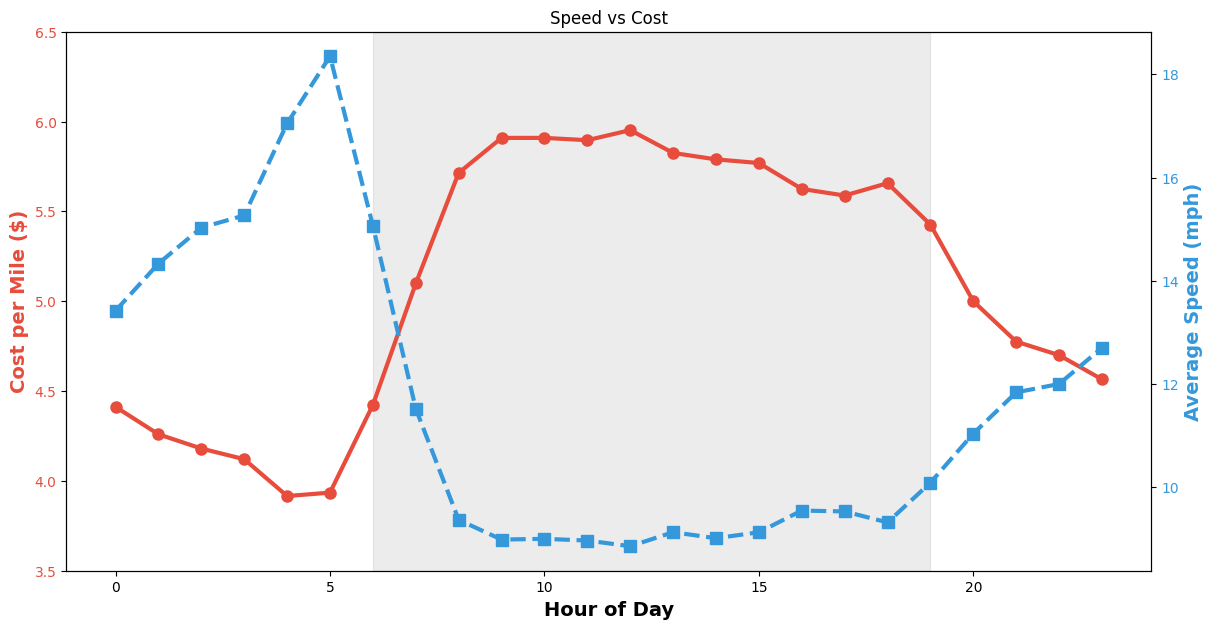

In [ ]:
# Calculate average speed (mph)
df_clean['speed_mph'] = (df_clean['trip_distance'] / df_clean['trip_duration_min']) * 60
df_clean = df_clean[(df_clean['speed_mph'] > 2) & (df_clean['speed_mph'] < 60)]

# Compare speed vs cost by hour
hourly_metrics = df_clean.groupby('hour').agg({
    'fare_per_mile': 'median',
    'speed_mph': 'median'
}).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 7))

# Cost per mile
color = '#e74c3c'
ax1.set_xlabel('Hour of Day', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cost per Mile ($)', color=color, fontsize=14, fontweight='bold')
ax1.plot(hourly_metrics['hour'], hourly_metrics['fare_per_mile'], 
         color=color, linewidth=3, marker='o', markersize=8, label='Cost per Mile')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(3.5, 6.5)

# Speed
ax2 = ax1.twinx()
color = '#3498db'
ax2.set_ylabel('Average Speed (mph)', color=color, fontsize=14, fontweight='bold')
ax2.plot(hourly_metrics['hour'], hourly_metrics['speed_mph'], 
         color=color, linewidth=3, marker='s', markersize=8, label='Speed', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
# ax2.invert_yaxis() 

# Highlight the correlation
ax1.axvspan(6, 19, alpha=0.15, color='gray')

# Title
ax1.set_title('Speed vs Cost')

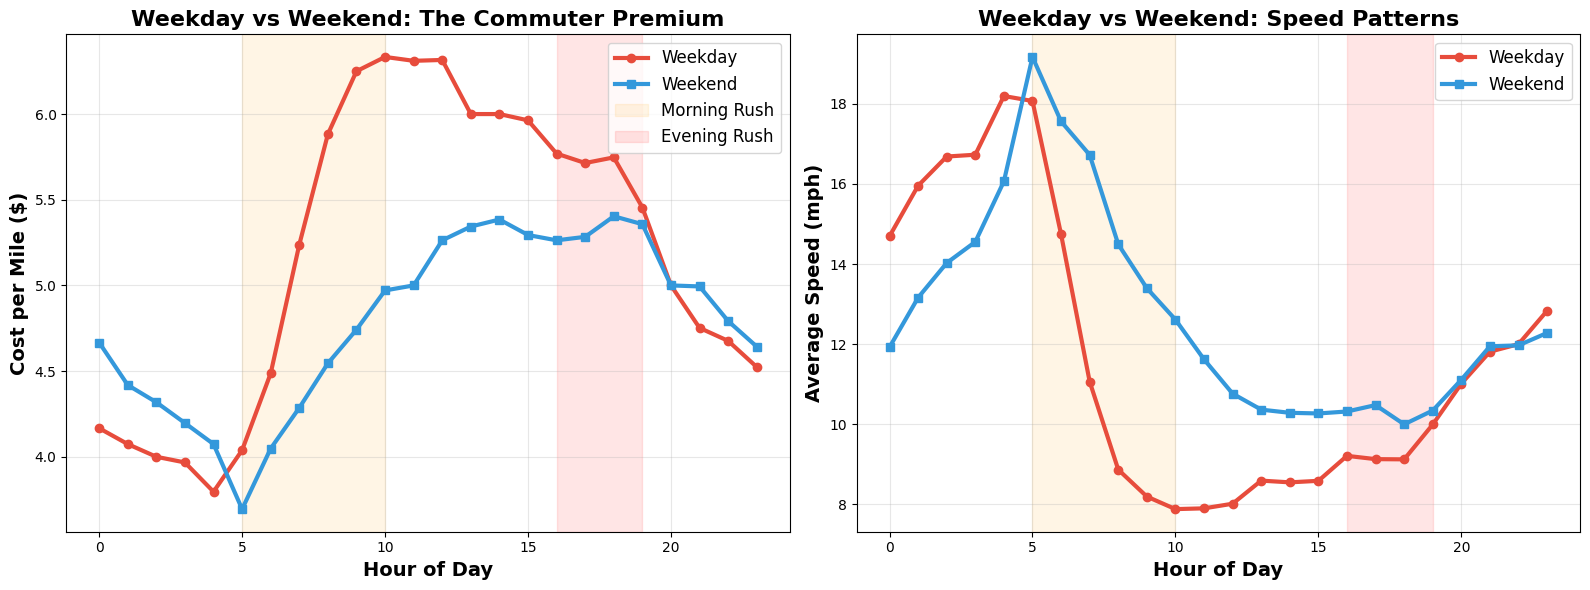


Weekday rush hour cost: $5.39/mile
Weekend same hours cost: $4.66/mile
Commuter premium: $0.73/mile (15.7%)


In [ ]:
df_clean['day_of_week'] = pd.to_datetime(df_clean['tpep_pickup_datetime']).dt.dayofweek
df_clean['is_weekend'] = df_clean['day_of_week'].isin([5, 6])  # Sat=5, Sun=6

weekday_hourly = df_clean[~df_clean['is_weekend']].groupby('hour').agg({
    'fare_per_mile': 'median',
    'speed_mph': 'median'
}).reset_index()
weekend_hourly = df_clean[df_clean['is_weekend']].groupby('hour').agg({
    'fare_per_mile': 'median',
    'speed_mph': 'median'
}).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Cost per mile
ax1.plot(weekday_hourly['hour'], weekday_hourly['fare_per_mile'], 
         linewidth=3, marker='o', label='Weekday', color='#e74c3c')
ax1.plot(weekend_hourly['hour'], weekend_hourly['fare_per_mile'], 
         linewidth=3, marker='s', label='Weekend', color='#3498db')
ax1.axvspan(5, 10, alpha=0.1, color='orange', label='Morning Rush')
ax1.axvspan(16, 19, alpha=0.1, color='red', label='Evening Rush')
ax1.set_xlabel('Hour of Day', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cost per Mile ($)', fontsize=14, fontweight='bold')
ax1.set_title('Weekday vs Weekend: The Commuter Premium', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Speed
ax2.plot(weekday_hourly['hour'], weekday_hourly['speed_mph'], 
         linewidth=3, marker='o', label='Weekday', color='#e74c3c')
ax2.plot(weekend_hourly['hour'], weekend_hourly['speed_mph'], 
         linewidth=3, marker='s', label='Weekend', color='#3498db')
ax2.axvspan(5, 10, alpha=0.1, color='orange')
ax2.axvspan(16, 19, alpha=0.1, color='red')
ax2.set_xlabel('Hour of Day', fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Speed (mph)', fontsize=14, fontweight='bold')
ax2.set_title('Weekday vs Weekend: Speed Patterns', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate the difference
rush_hours = [5, 6, 7, 8, 9, 16, 17, 18]
weekday_rush_cost = weekday_hourly[weekday_hourly['hour'].isin(rush_hours)]['fare_per_mile'].mean()
weekend_rush_cost = weekend_hourly[weekend_hourly['hour'].isin(rush_hours)]['fare_per_mile'].mean()

print(f"\nWeekday rush hour cost: ${weekday_rush_cost:.2f}/mile")
print(f"Weekend same hours cost: ${weekend_rush_cost:.2f}/mile")
print(f"Commuter premium: ${weekday_rush_cost - weekend_rush_cost:.2f}/mile ({((weekday_rush_cost/weekend_rush_cost - 1)*100):.1f}%)")

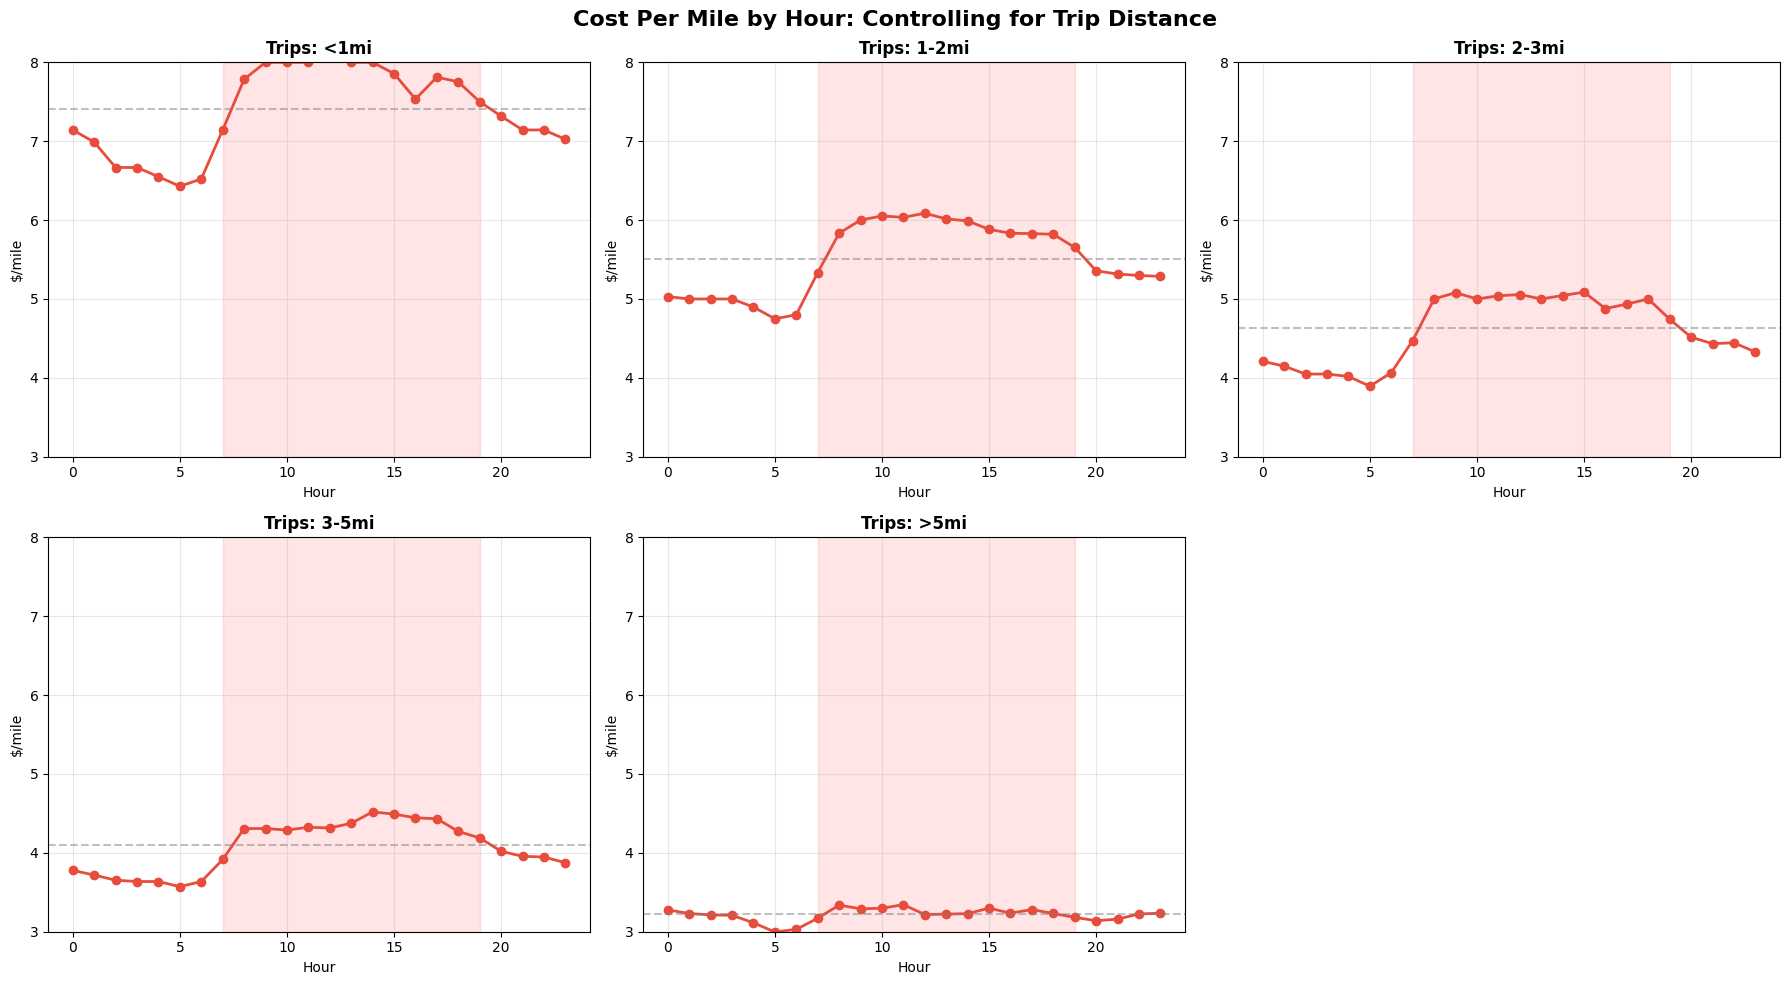

In [ ]:
# Bin trips by distance
df_clean['distance_bin'] = pd.cut(df_clean['trip_distance'], 
                                    bins=[0, 1, 2, 3, 5, 100],
                                    labels=['<1mi', '1-2mi', '2-3mi', '3-5mi', '>5mi'])

# For each distance bin, show cost per mile by hour
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Cost Per Mile by Hour: Controlling for Trip Distance', 
             fontsize=16, fontweight='bold')

for idx, distance_cat in enumerate(['<1mi', '1-2mi', '2-3mi', '3-5mi', '>5mi']):
    ax = axes[idx // 3, idx % 3]
    
    subset = df_clean[df_clean['distance_bin'] == distance_cat]
    hourly = subset.groupby('hour')['fare_per_mile'].median()
    
    ax.plot(hourly.index, hourly.values, linewidth=2, marker='o', color='#e74c3c')
    ax.axhline(y=hourly.median(), color='gray', linestyle='--', alpha=0.5)
    ax.axvspan(7, 19, alpha=0.1, color='red')
    ax.set_title(f'Trips: {distance_cat}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Hour', fontsize=10)
    ax.set_ylabel('$/mile', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(3, 8)

axes[1, 2].axis('off') # Hide the 6th subplot

plt.tight_layout()
plt.show()

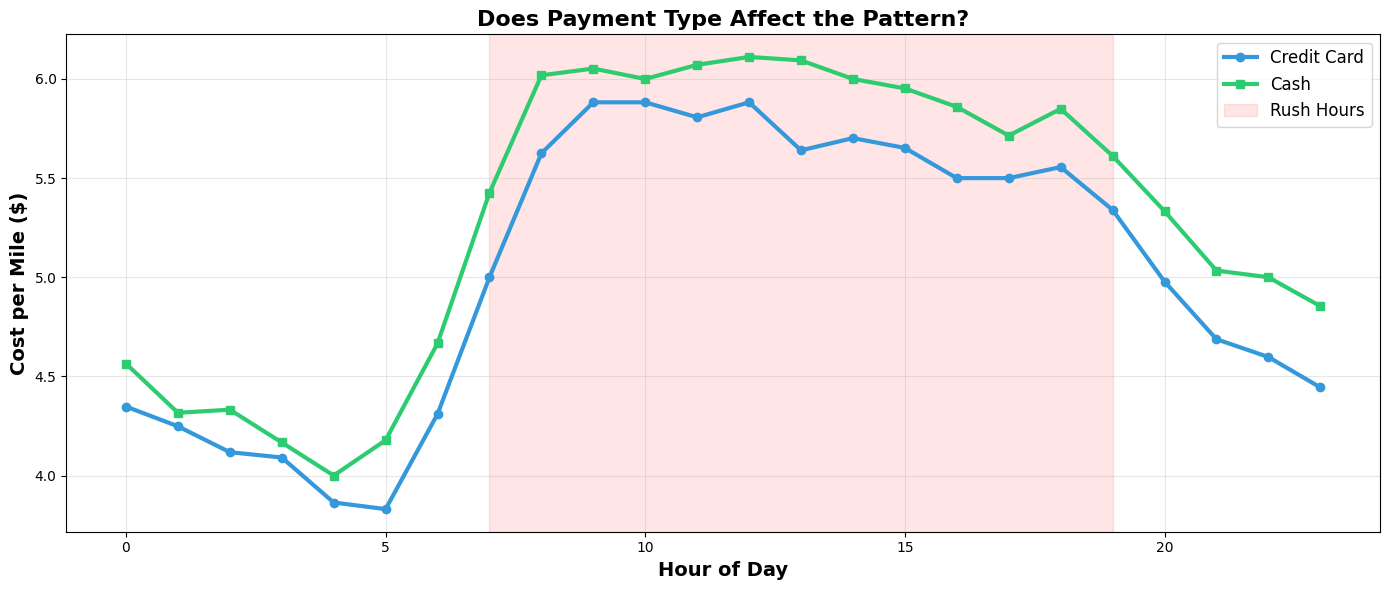

In [ ]:
# Compare credit vs cash
df_credit = df_clean[df_clean['payment_type'] == 1]  # Credit card
df_cash = df_clean[df_clean['payment_type'] == 2]    # Cash

credit_hourly = df_credit.groupby('hour')['fare_per_mile'].median()
cash_hourly = df_cash.groupby('hour')['fare_per_mile'].median()

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(credit_hourly.index, credit_hourly.values, 
        linewidth=3, marker='o', label='Credit Card', color='#3498db')
ax.plot(cash_hourly.index, cash_hourly.values, 
        linewidth=3, marker='s', label='Cash', color='#2ecc71')
ax.axvspan(7, 19, alpha=0.1, color='red', label='Rush Hours')

ax.set_xlabel('Hour of Day', fontsize=14, fontweight='bold')
ax.set_ylabel('Cost per Mile ($)', fontsize=14, fontweight='bold')
ax.set_title('Does Payment Type Affect the Pattern?', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()